# Color Imaging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import patches as patch
from matplotlib.lines import Line2D
from scipy.constants import h, c, k
from scipy.io import loadmat

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1

## CIE 1964

In [2]:
CIE = pd.read_csv("Data/CIE_xyz_1964_10deg.csv", header = None)
CIE_data = pd.DataFrame.to_numpy(pd.DataFrame(CIE))

In [3]:
CIE_wavelengths = CIE_data[:,0]
x_bar, y_bar, z_bar = CIE_data[:,1], CIE_data[:,2], CIE_data[:,3]
z_bar = np.nan_to_num(z_bar)

In [4]:
# Desired wavelengths
visible_wavelengths = np.arange(380, 780 + 1, 10)
spectrum_wavelengths = np.linspace(400, 800, len(CIE_wavelengths))

### Color matching functions

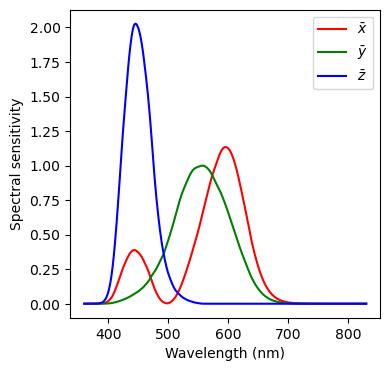

In [5]:
CIE_CMF = [x_bar, y_bar, z_bar]
labels = [r"$\bar{x}$", r"$\bar{y}$", r"$\bar{z}$"]
colors = ["red", "green", "blue"]

for i, CMF in enumerate(CIE_CMF):
    plt.plot(CIE_wavelengths, CMF, color = colors[i], label = labels[i])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral sensitivity")
    plt.legend()
    
plt.savefig("Results/CIE CMFs.png", dpi = 300)

### Tristimulus values

In [6]:
X, Y, Z, x, y, z = [], [], [], [], [], []

for wavelength in visible_wavelengths:
    
    # Calculate the Gaussian spectrum for specific wavelength
    amplitude, stdev = 1.0, 1.0
    light_spectrum = amplitude * np.exp(-((spectrum_wavelengths - wavelength)**2) / (2*stdev**2))
    
    # Locate the index of the target wavelength in the CMF data
    idx = np.argmin(np.abs(CIE_wavelengths - wavelength))
    
    # Calculate the tristimulus values for a specific wavelength
    X_val = np.trapz(x_bar[idx] * light_spectrum, spectrum_wavelengths)
    Y_val = np.trapz(y_bar[idx] * light_spectrum, spectrum_wavelengths)
    Z_val = np.trapz(z_bar[idx] * light_spectrum, spectrum_wavelengths)
    
    total_tristimulus = X_val + Y_val + Z_val
    x_val = X_val / total_tristimulus
    y_val = Y_val / total_tristimulus
    z_val = 1 - x_val - y_val
    
    X.append(X_val), Y.append(Y_val), Z.append(Z_val)
    x.append(x_val), y.append(y_val), z.append(z_val)

In [7]:
def CIExy(wavelength, spectrum, standard_observer):
    trisim_XYZ = []
    for i in range(len(standard_observer)):
        integrand = spectrum * standard_observer[i]
        integral = np.trapz(integrand, wavelength)
        trisim_XYZ.append(integral)
    x, y, z = trisim_XYZ / np.sum(trisim_XYZ)
    return x, y

In [8]:
x_bound, y_bound = [], []

for wavelength in visible_wavelengths:
    dirac_delta_spec = np.zeros_like(CIE_wavelengths)
    dirac_delta_spec[np.where(CIE_wavelengths == wavelength)] = 1
    x, y = CIExy(CIE_wavelengths, dirac_delta_spec, [x_bar, y_bar, z_bar])
    x_bound.append(x), y_bound.append(y)

### Planckian locus

In [9]:
def blackbody_radiation(wavelength, temperature):
    c1 = 2*np.pi*h*c*c
    c2 = h*c/k
    return c1/(wavelength**5) * 1/(np.exp(c2/wavelength/temperature) - 1)

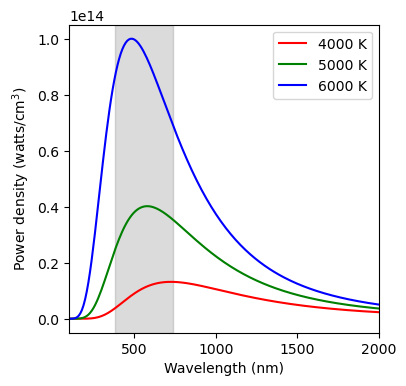

In [10]:
wavelength_vals = np.linspace(100, 10000, 1000)
temperature_vals = [4000, 5000, 6000]
colors = ["red", "green", "blue"]
spectrum_vals = []

for temp in temperature_vals:
    blackbody_spectrum = blackbody_radiation(wavelength_vals * 1e-9, temp)
    spectrum_vals.append(blackbody_spectrum)

fig, ax = plt.subplots()
    
for (i, temp), color in zip(enumerate(temperature_vals), colors):
    ax.plot(wavelength_vals, spectrum_vals[i], label = "{:.0f} K".format(temp), color = color)
    ax.axvspan(380, 740, alpha = 0.10, color = "gray")
    ax.set(xlabel = "Wavelength (nm)", ylabel = "Power density (watts/$\mathrm{cm}^3$)", xlim = (100, 2000))
    ax.legend()
    
plt.savefig("Results/blackbody radiation.png", dpi = 300)

In [11]:
# Desired temperatures
blackbody_temps = np.arange(1000, 10001, 1000)
x_locus, y_locus = [], []

for temp in blackbody_temps:
    blackbody_spectrum = blackbody_radiation(CIE_wavelengths * 1e-9, temp)
    x, y = CIExy(CIE_wavelengths, blackbody_spectrum, [x_bar, y_bar, z_bar])
    x_locus.append(x), y_locus.append(y)

### CIE 1964 $xy$ chromaticity

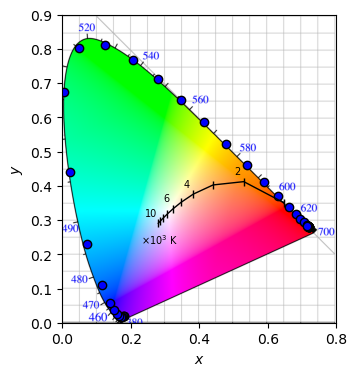

In [12]:
CIExy_tongue = plt.imread("CIExy.png")

plt.imshow(CIExy_tongue, extent = (0, 0.8, 0, 0.9))
plt.scatter(x_bound, y_bound, color = "blue", edgecolor = "black")
plt.plot(x_locus, y_locus, linewidth = 1, marker = "|", color = "black")
plt.xlabel("$x$")
plt.ylabel("$y$")

for i, mag in enumerate(blackbody_temps):
    if i % 2 == 1:
        if (mag // 1000) != 8:
            plt.annotate(str(mag//1000), (x_locus[i] - 0.02, y_locus[i] + 0.03), fontsize = 7,
                 horizontalalignment = "center", verticalalignment = "center")
            
plt.text(0.23, 0.23, r"$\times 10^3$ K", fontsize = 7)
plt.savefig("Results/CIExy tongue replicated.png", dpi = 300)

***
## CIE Illuminant D65

In [13]:
CIE_D65 = np.genfromtxt("Data/CIE_std_illum_D65.csv", delimiter = ",", unpack = True).T
D65_wavelengths, D65_spectrum = CIE_D65[:,0], CIE_D65[:,1]

Code below taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python. This converts a given wavelength of light to an approximate RGB color value. The wavelength must be given in nanometers in the range from 380 nm through 750 nm (789 THz through 400 THz). Based on code by [Dan Bruton](http://www.physics.sfasu.edu/astro/color/spectra.html). Additionally alpha value set to 0.5 outside range.

In [14]:
def wavelength_to_rgb(wavelength, gamma = 0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750: A = 1
    else: A=0.5
    if wavelength < 380: wavelength = 380
    if wavelength > 750: wavelength = 750
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

In [15]:
# Initialize the RGB colormap
clim = (350, 780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0], clim[1] + 1, 2)
color_list = list(zip(norm(wl), [wavelength_to_rgb(w) for w in wl]))
spectral_map = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", color_list)

y_extent = np.linspace(0, 120, 1000)
x_map, y_map = np.meshgrid(CIE_D65[:,0], y_extent)
extent = (np.min(CIE_D65[:,0]), np.max(CIE_D65[:,0]), np.min(y_extent), np.max(y_extent))

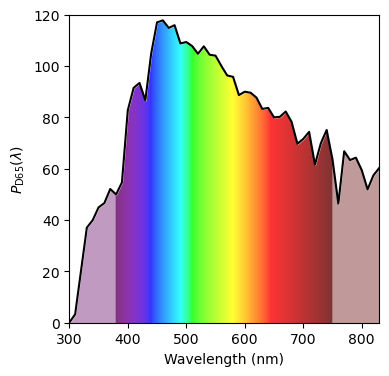

In [16]:
fig, ax = plt.subplots()

ax.plot(CIE_D65[:,0], CIE_D65[:,1], color = "black")
ax.imshow(x_map, clim = clim, extent = extent, cmap = spectral_map, alpha = 0.8, aspect = "auto")
ax.fill_between(CIE_D65[:,0], CIE_D65[:,1], 120, color = "white")
ax.set(xlabel = "Wavelength (nm)", ylabel = r"$P_{\mathrm{D65}} (\lambda)$")

fig.savefig("Results/D65 illuminant distribution.png", dpi = 300)

***
## CIE $u'v'$ color space

In [17]:
def CIELuv(x, y):
    denom = -2*x + 12*y + 3
    u_prime = 4*x / denom
    v_prime = 9*y / denom
    return u_prime, v_prime

In [18]:
u_bound, v_bound = [], []

for i in range(len(x_bound)):
    u_p, v_p = CIELuv(x_bound[i], y_bound[i])
    u_bound.append(u_p), v_bound.append(v_p)

In [19]:
u_locus, v_locus = [], []

for i in range(len(x_locus)):
    u_p, v_p = CIELuv(x_locus[i], y_locus[i])
    u_locus.append(u_p), v_locus.append(v_p)

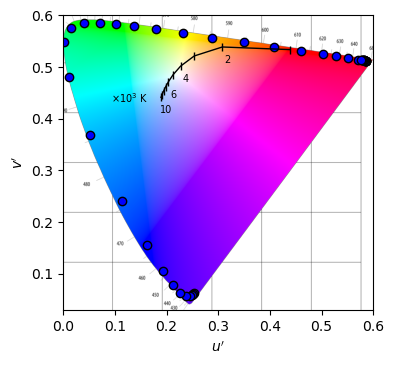

In [20]:
CIELuv_diagram = plt.imread("CIE Luv.png")

plt.imshow(CIELuv_diagram, extent = (0, 0.6, 0.03, 0.6))
plt.scatter(u_bound, v_bound, color = "blue", edgecolor = "black")
plt.plot(u_locus, v_locus, linewidth = 1, marker = "|", color = "black")
plt.xlabel("$u'$")
plt.ylabel("$v'$")

for i, mag in enumerate(blackbody_temps):
    if i % 2 == 1:
        if (mag // 1000) != 8:
            plt.annotate(str(mag//1000), (u_locus[i] + 0.01, v_locus[i] - 0.025), fontsize = 7,
                 horizontalalignment = "center", verticalalignment = "center")
            
plt.text(0.093, 0.43, r"$\times 10^3$ K", fontsize = 7)
plt.savefig("Results/CIE Luv diagram replicated.png", dpi = 300)

***
## Color simulations

### Interpolating the dataset

- `munsell` is a 61 x 1250 matrix where each column is one 61 component spectrum
- `S` is a 1250 x 15 matrix where 1st row is the label of 1st spectrum in munsell matrix, and so on
- `C` is a 16 x 1250 matrix where 1st column consists of the color coordinates of the 1st spectrum in munsell matrix, the 2nd column consists of the color coordinates of the 2nd spectrum and so on. The color coordinates are calculated by using D65 light source and they are stored in the column vectors in following order: x, y, z, X, Y, Z, R, G, B, L*, a*, b*, u, v, u*, v*

In [21]:
munsell_data = loadmat("Data/munsell400_700_5.mat")
munsell_ref = pd.DataFrame.to_numpy(pd.DataFrame(munsell_data["munsell"]))
munsell_code = pd.DataFrame.to_numpy(pd.DataFrame(munsell_data["S"]))
munsell_coords = pd.DataFrame.to_numpy(pd.DataFrame(munsell_data["C"]))

LED_data = np.genfromtxt("Data/CIE_illum_LEDs_1nm.csv", delimiter = ",", unpack = True).T
LED_wavelengths, LED_emittance = LED_data[:,0], LED_data[:,1:]

In [22]:
wavelengths = np.arange(400, 700 + 1, 5)

# Interpolate the RGB sensitivies from CIE 1964 dataset
red = np.interp(wavelengths, CIE_wavelengths, x_bar)
green = np.interp(wavelengths, CIE_wavelengths, y_bar)
blue = np.interp(wavelengths, CIE_wavelengths, z_bar)

# Interpolate the spectrum of the illuminants
D65 = np.interp(wavelengths, D65_wavelengths, D65_spectrum)
LED = np.zeros(shape = (len(wavelengths), np.shape(LED_data)[1] - 1))

for i in range(1, np.shape(LED_data)[1]):
    LED[:,i-1] = np.interp(wavelengths, LED_wavelengths, LED_emittance[:,i-1])

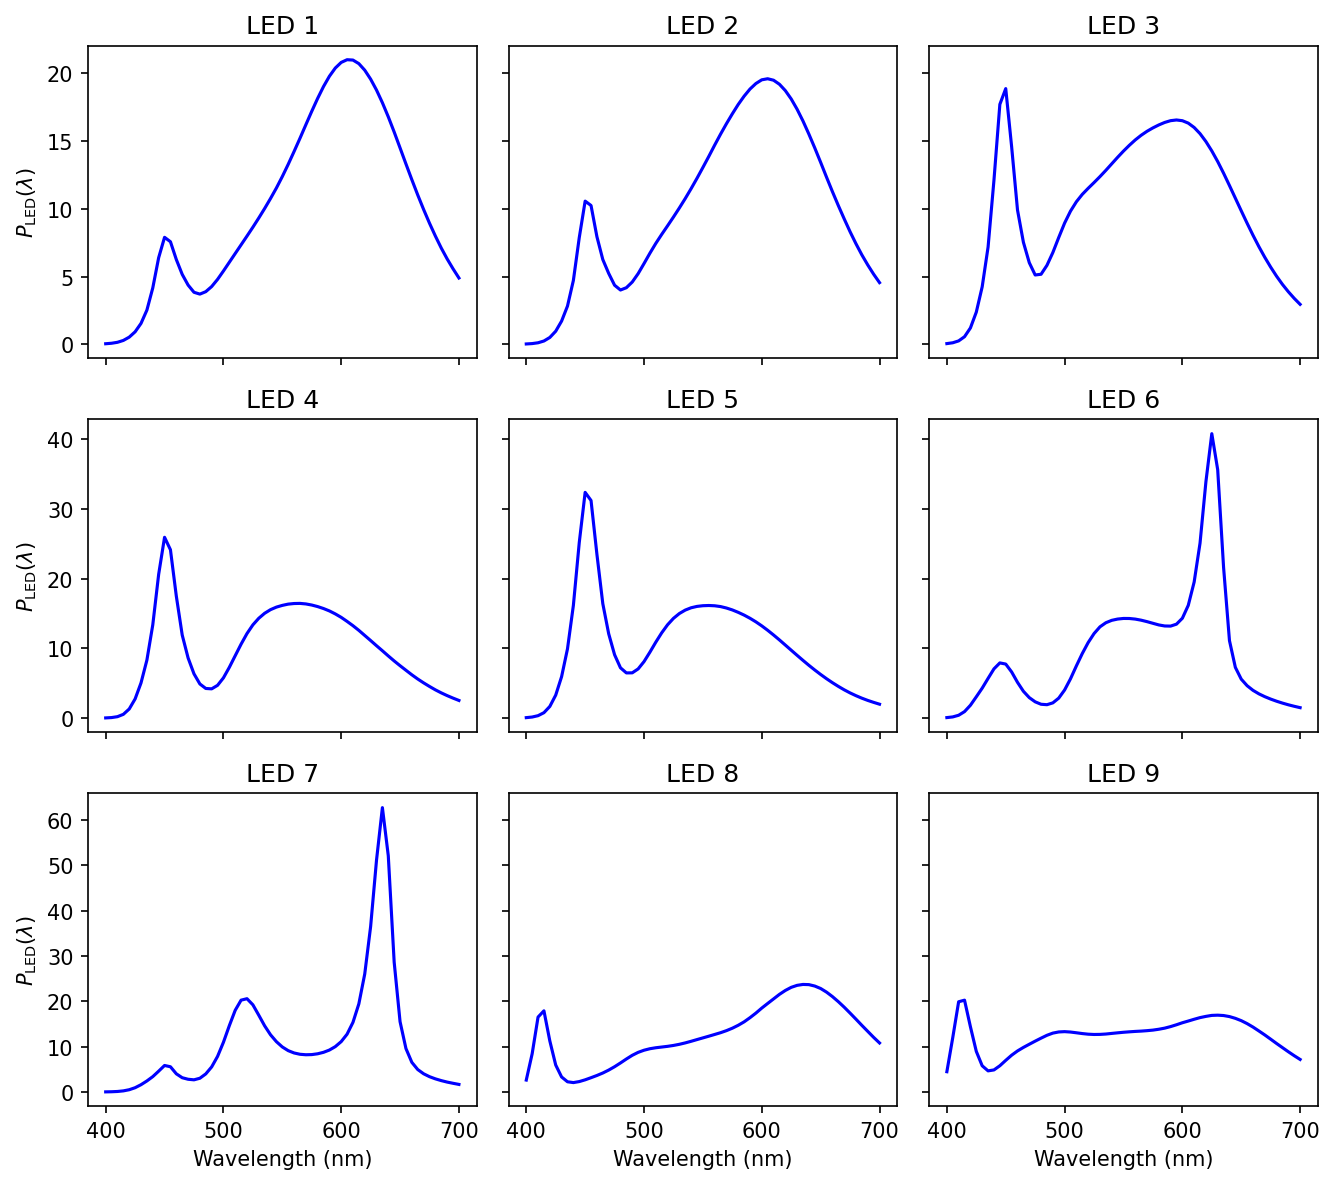

In [23]:
fig, ax = plt.subplots(3, 3, figsize = (9, 8), dpi = 150, sharex = "col", sharey = "row", tight_layout = True)
ax = ax.flatten()

for i in range(np.shape(LED)[1]):
    ax[i].plot(wavelengths, LED[:,i], color = "blue")
    ax[i].set_title("LED {}".format(i+1))
    if i == 6 or i == 7 or i == 8:
        ax[i].set_xlabel("Wavelength (nm)")
    if i == 0 or i == 3 or i == 6:
        ax[i].set_ylabel(r"$P_{\mathrm{LED}} (\lambda)$")
        
fig.savefig("Results/LED emittance spectra.png", dpi = 300)

### CIE L$ab$ color space

Compute the L$ab$ coordinates of these 3 chips under two different lights - D65 and a white LED. For each 
chip compute the color difference between the observed color under D65 and white LED and remark if the color difference will be noticeable.

In [24]:
def f(t):
    if t <= (6/29)**3:
        return 7.787*t + 16/116
    else:
        return t**(1/3)
    
def luminance(t):
    if t <= (6/29)**3:
        return (29/3)**3 * t
    else:
        return 116*t**(1/3) - 16

In [25]:
def CIELab(sensitivity, illuminant, reflectance):
    #  All arrays must have same size by interpolation
    # Illuminant as the spectrum  and RGB sensitivity as the standard observer 
    trisim_light, trisim_obj = [], []
    
    for i in range(len(sensitivity)):
        ambient_light = np.trapz(illuminant * sensitivity[i]) # [X_n, Y_n, Z_n]
        colored_obj =  np.trapz(reflectance * illuminant * sensitivity[i]) # [X, Y, Z]
        trisim_light.append(ambient_light), trisim_obj.append(colored_obj)
    
    L = luminance(trisim_obj[1]/trisim_light[1])
    a = 500 * (f(trisim_obj[0]/trisim_light[0]) - f(trisim_obj[2]/trisim_light[2]))
    b = 500 * (f(trisim_obj[1]/trisim_light[1]) - f(trisim_obj[2]/trisim_light[2]))
    
    return L, a, b

### CIE76 color difference metric ($\Delta \mathrm{E}_{76}$)

In [26]:
def del_E(Lab_1, Lab_2):
    diff = np.sqrt((Lab_1[0] - Lab_2[0])**2 + (Lab_1[1] - Lab_2[1])**2 + (Lab_1[2] - Lab_2[2])**2)
    return diff

### Munsell color chips

In [27]:
# RGBs for different illuminants at a single chip reflectance only
def Munsell_Chip(sensitivity, illuminant_1, illuminant_2, reflectance):
    trisim_light_1, trisim_obj_1, trisim_light_2, trisim_obj_2 = [], [], [], []
    
    for i in range(len(sensitivity)):

        ambient_light_1 = np.trapz(illuminant_1 * sensitivity[i]) # [X_n, Y_n, Z_n]
        colored_obj_1 = np.trapz(reflectance * illuminant_1 * sensitivity[i]) # [X, Y, Z]
        trisim_light_1.append(ambient_light_1), trisim_obj_1.append(colored_obj_1)

        ambient_light_2 = np.trapz(illuminant_2 * sensitivity[i]) # [X_n, Y_n, Z_n]
        colored_obj_2 = np.trapz(reflectance * illuminant_2 * sensitivity[i])  # [X, Y, Z]
        trisim_light_2.append(ambient_light_2), trisim_obj_2.append(colored_obj_2)

    RGB_1 = np.array(trisim_obj_1) / np.max(trisim_obj_1)
    RGB_2 = np.array(trisim_obj_2) / np.max(trisim_obj_2)
    
    return RGB_1, RGB_2

In [28]:
def Munsell_Comparison(sensitivity, illuminant_1, illuminant_2, reflectances, source_1, source_2):
    fig, ax = plt.subplots(1, 3, figsize = (6, 1.75), dpi = 150, tight_layout = True)
    
    for i in range(len(reflectances)):
        
        # Set actual rendition as facecolors on succeeding plots
        RGB_actual = munsell_coords[6:9,reflectances[i]]
        ax[i].set_facecolor((np.array(RGB_actual)/np.max(RGB_actual)))
        
        # Render colored patches at different illuminants
        RGB_1, RGB_2 = Munsell_Chip(sensitivity, illuminant_1, illuminant_2, munsell_ref[:,reflectances[i]])
        rect_1 = patch.Rectangle((550, 0), 150, 1, facecolor = ((RGB_2)))
        rect_2 = patch.Rectangle((550, 0.5), 150, 1, facecolor = ((RGB_1)))
        illuminant_rect_1 = patch.Rectangle((401, 0.51), 299, 0.48, lw = 2, edgecolor = "b", facecolor = "none")
        illuminant_rect_2 = patch.Rectangle((401, 0.01), 299, 0.48, lw = 2, edgecolor = "r", facecolor = "none")
        ax[i].add_patch(rect_1)
        ax[i].add_patch(rect_2)
        ax[i].add_patch(illuminant_rect_1)
        ax[i].add_patch(illuminant_rect_2)
        
        # Compute for color difference metric
        Lab_1 = CIELab(sensitivity, illuminant_1, munsell_ref[:,reflectances[i]])
        Lab_2 = CIELab(sensitivity, illuminant_2, munsell_ref[:,reflectances[i]])
        del_E76 = np.round(del_E(Lab_1, Lab_2), 2)
        ax[i].set_title("$\Delta$E$_{76}$ = " + f"{del_E76:.2f}", fontsize = 8)
        
        ax[i].set(xlim = (400,700), ylim = (0,1), xticks = [], yticks = [])
        
    # Set legends
    illuminant_label_1 = patch.Patch(edgecolor = "blue", facecolor = "none", label = str(source_1))
    illuminant_label_2 = patch.Patch(edgecolor = "red", facecolor = "none", label = str(source_2))
    legend_elements = [illuminant_label_1, illuminant_label_2]
    legend = ax[2].legend(handles = legend_elements, bbox_to_anchor = (1.05, 0.70), fontsize = 8, 
                           facecolor = "gray", edgecolor = "black", framealpha = 0.5, fancybox = True)

### Illuminant D65 vs White LED 4

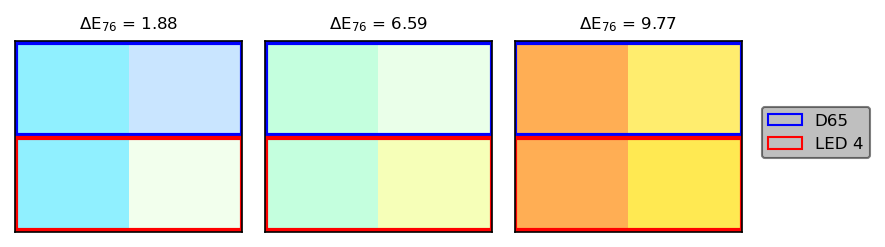

In [29]:
Munsell_Comparison([red, green, blue], D65, LED[:,3], [365, 420, 1240], "D65", "LED 4")
plt.savefig("Results/munsell 1 d65 vs led 4.png", dpi = 300)

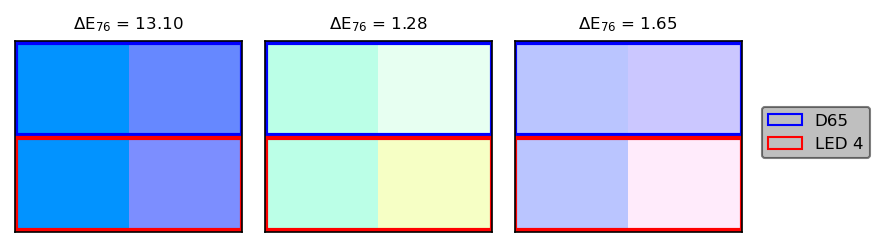

In [30]:
Munsell_Comparison([red, green, blue], D65, LED[:,3], [360, 720, 1080], "D65", "LED 4")
plt.savefig("Results/munsell 2 d65 vs led 4.png", dpi = 300)

### White LED 4 vs White LED 5

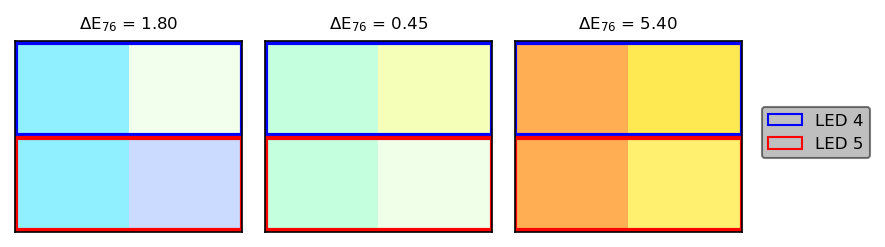

In [31]:
Munsell_Comparison([red, green, blue], LED[:,3], LED[:,4], [365, 420, 1240], "LED 4", "LED 5")
plt.savefig("Results/munsell 1 led 4 vs led 5.png", dpi = 300)

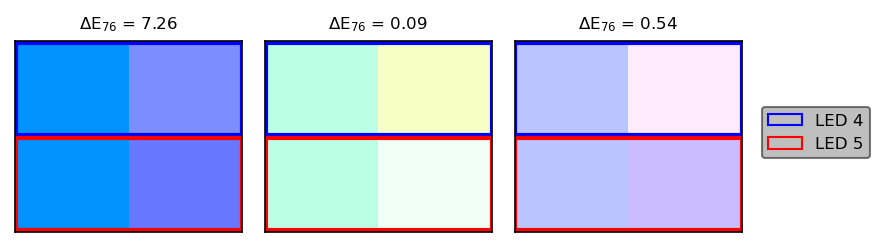

In [32]:
Munsell_Comparison([red, green, blue], LED[:,3], LED[:,4], [360, 720, 1080], "LED 4", "LED 5")
plt.savefig("Results/munsell 2 led 4 vs led 5.png", dpi = 300)

***
## Color rendering
### Interpolating the dataset

In [33]:
canon_400d_data = np.loadtxt("Data/canon_400d.spectra.txt")
canon_wavelengths, canon_channels = canon_400d_data[:,0], canon_400d_data[:,1:]

# Interpolate the Canon channel sensitivities
canon_red = np.interp(wavelengths, canon_wavelengths, canon_channels[:,0])
canon_green = np.interp(wavelengths, canon_wavelengths, canon_channels[:,1])
canon_blue = np.interp(wavelengths, canon_wavelengths, canon_channels[:,2])

# Interpolate the reflectance of every Macbeth patch
macbeth_data = pd.DataFrame.to_numpy(pd.read_csv("Data/MacbethColorChecker.csv"))
macbeth_wavelengths, macbeth_ref_init = macbeth_data[:,0], macbeth_data[:,1:]
macbeth_ref = np.zeros(shape = (len(wavelengths), np.shape(macbeth_ref_init)[1]))

for i in range(1, np.shape(macbeth_data)[1]):
    macbeth_ref[:,i-1] = np.interp(wavelengths, macbeth_wavelengths, macbeth_ref_init[:,i-1])

### Macbeth reflectances

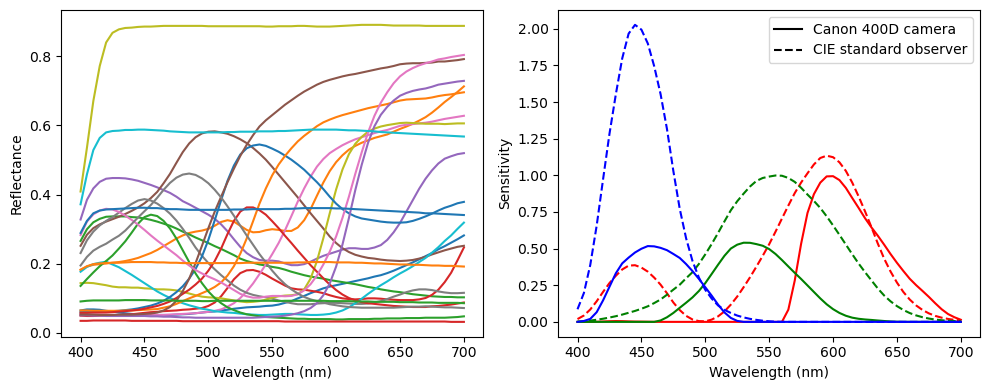

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)

canon_sensitivities = [canon_red, canon_green, canon_blue]
cie_channels = [red, green, blue]
colors = ["red", "green", "blue"]

for i in range(np.shape(macbeth_ref)[1]):
    ax[0].plot(wavelengths, macbeth_ref[:,i])
    ax[0].set(xlabel = "Wavelength (nm)", ylabel = "Reflectance")

for i, canon_channel in enumerate(canon_sensitivities):
    ax[1].plot(wavelengths, canon_channel, color = colors[i])
    ax[1].plot(wavelengths, cie_channels[i], color = colors[i], linestyle = "--")
    
canon_400d_label = Line2D([0,1], [0,1], linewidth = 1.5, color = "black", label = "Canon 400D camera")
cie_sho_label = Line2D([0,1], [0,1], linewidth = 1.5, ls = "--", c = "k", label = "CIE standard observer")
ax[1].legend(handles = [canon_400d_label, cie_sho_label])
ax[1].set(xlabel = "Wavelength (nm)", ylabel = "Sensitivity")

fig.savefig("Results/macbeth reflectances and canon sensitivity.png", dpi = 300)

### Macbeth chart

In [35]:
def Macbeth_Patch(sensitivity, illuminant, reflectance):
    trisim_light, trisim_obj = [], []
    
    for i in range(len(sensitivity)):
        
        ambient_light = np.trapz(illuminant * sensitivity[i])  # [X_n, Y_n, Z_n]
        colored_obj = np.trapz(reflectance * illuminant * sensitivity[i]) / ambient_light # [X, Y, Z]
        
        if colored_obj < 0: colored_obj = 0
        if colored_obj > 255: colored_obj = 255
        
        trisim_light.append(ambient_light), trisim_obj.append(colored_obj)
        
    R, G, B = np.array(trisim_obj)
    
    return R, G, B

In [36]:
def Macbeth_Comparison(sensitivity, illuminant, source_2, source_1 = "CIE 1964 $10^{\circ}$"):
    fig, ax = plt.subplots(4, 6, figsize = (7.85, 5), dpi = 150)
    plt.subplots_adjust(hspace = 0.35)
    ax = ax.flatten()
    
    for i in range(np.shape(macbeth_ref)[1]):
        
        # Set actual rendition on standard observer as facecolors on all plots
        RGB_actual = Macbeth_Patch([red, green, blue], illuminant, macbeth_ref[:,i])
        ax[i].set_facecolor((RGB_actual))
        
        # Render each colored patch at different sensitivities
        RGB = Macbeth_Patch(sensitivity, illuminant, macbeth_ref[:,i])
        rect = patch.Rectangle((550, 0), 150, 1, facecolor = ((RGB)))
        source_rect_1 = patch.Rectangle((402, 0.02), 144, 0.97, lw = 1.10, edgecolor = "b", facecolor = "none")
        source_rect_2 = patch.Rectangle((550, 0.02), 146, 0.97, lw = 1.10, edgecolor = "r", facecolor = "none")
        ax[i].add_patch(rect)
        ax[i].add_patch(source_rect_1)
        ax[i].add_patch(source_rect_2)
        
        # Compute for color difference metric
        Lab_1 = CIELab([red, green, blue], illuminant, macbeth_ref[:,i])
        Lab_2 = CIELab(sensitivity, illuminant, macbeth_ref[:,i])
        del_E76 = np.round(del_E(Lab_1, Lab_2), 2)
        ax[i].set_title("$\Delta$E$_{76}$ = " + f"{del_E76:.2f}", fontsize = 7.15)
        
        ax[i].set(xlim = (400,700), ylim = (0,1), xticks = [], yticks = [])
        
    # Set legends
    illuminant_label_1 = patch.Patch(edgecolor = "blue", facecolor = "none", label = str(source_1))
    illuminant_label_2 = patch.Patch(edgecolor = "red", facecolor = "none", label = str(source_2))
    legend_elements = [illuminant_label_1, illuminant_label_2]
    legend = ax[5].legend(handles = legend_elements, bbox_to_anchor = (1.05, 1.70), ncol = 2, fontsize = 7.15, 
                          facecolor = "gray", edgecolor = "black", framealpha = 0.5, fancybox = True)

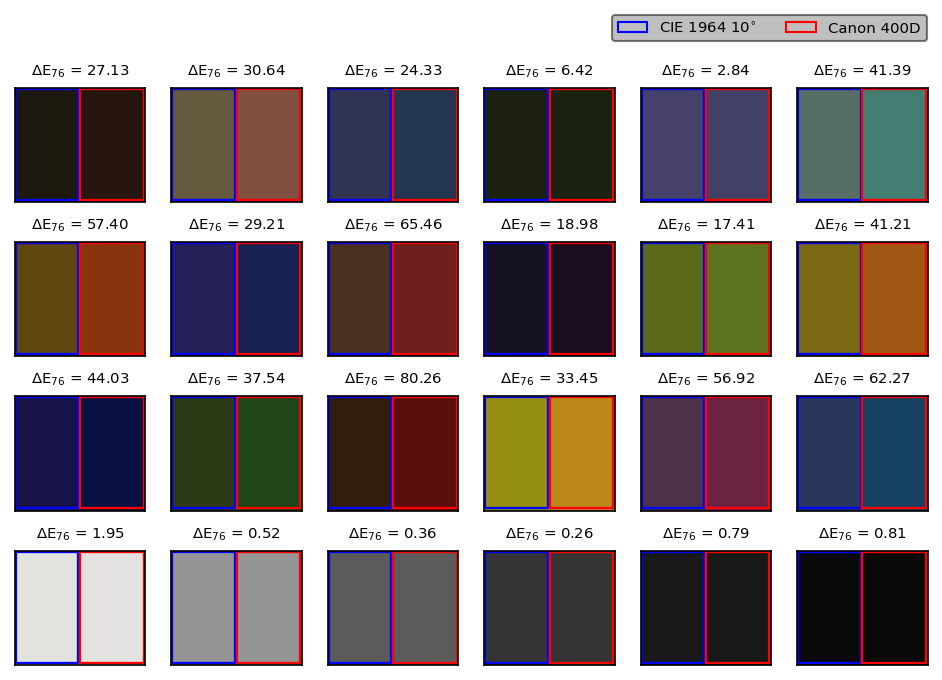

In [37]:
Macbeth_Comparison([canon_red, canon_green, canon_blue], D65, "Canon 400D")
plt.savefig("Results/macbeth canon d65.png", dpi = 300)